# Embed grid of 10,000 FSPS spectra

In [81]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.plotting import setup_text_plots
import h5py

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=16, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=10)
mpl.rc('axes', labelweight='black')

In [4]:
# code from megaman_spectra.py 

from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding
from scipy.io import mmwrite
from scipy.sparse.csgraph import connected_components

f = h5py.File('../data/1e4_model_spectra.hdf5','r')
spectra = f['spectra'][:]
wave = f['wave'][:]
taus = f['taus'][:]
ages = f['ages'][:]
zs = f['zs'][:]
dusts = f['dusts'][:]
sigmas = f['sigmas'][:]
f.close()

In [138]:
radius = 1.05 # reduced from original 35000 to run on narrower spectral range/normalized data
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print "Number of connected components: ", n
wh = np.where(labels > 0)
#geom.X = np.delete(geom.X, wh, 0) 
#
#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 0)
#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 1)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

mmwrite('embed3d_1e4_model_spectra.mtx', embed)

Number of connected components:  5


In [139]:
def plot_embed(color, label, axlim=True):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    a = ax[0].scatter(embed[:,0], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(a, ax=ax[0], label=label)
    ax[0].set_xlabel('dim0')
    ax[0].set_ylabel('dim1')

    b = ax[1].scatter(embed[:,2], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax[1], label=label)
    ax[1].set_xlabel('dim2')
    ax[1].set_ylabel('dim1')
    
    if axlim:
        ax[0].set_xlim([-0.03,0.02])
        ax[0].set_ylim([-0.03, 0.05])
        ax[1].set_xlim([-0.03,0.02])
        ax[1].set_ylim([-0.03, 0.05])
        
    plt.tight_layout()

## Plots here show result for r=1.05

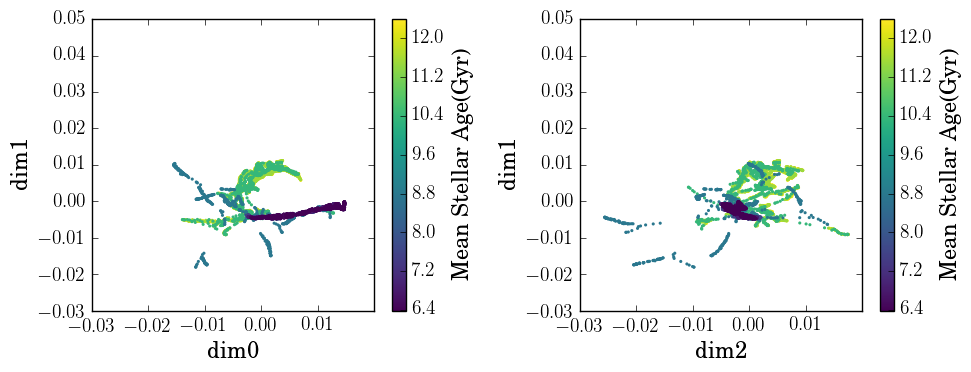

In [140]:
plot_embed(ages, 'Mean Stellar Age(Gyr)', axlim=True)

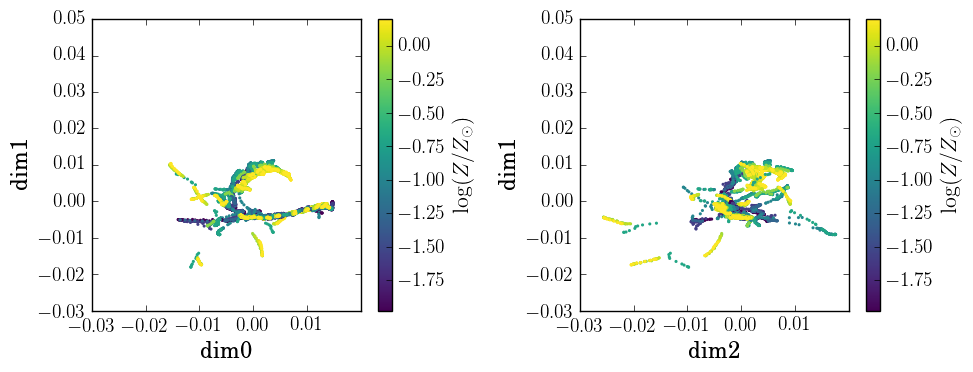

In [141]:
plot_embed(zs, r'$\log(Z/Z_\odot)$', axlim=True)

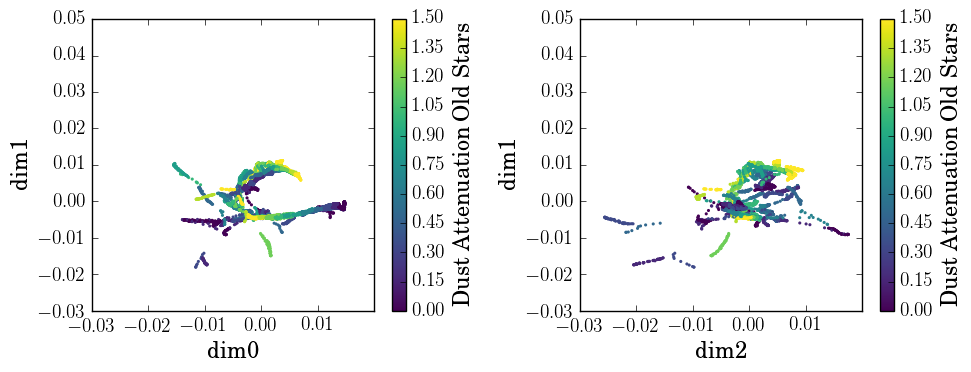

In [143]:
plot_embed(dusts, 'Dust Attenuation Old Stars', axlim=True)

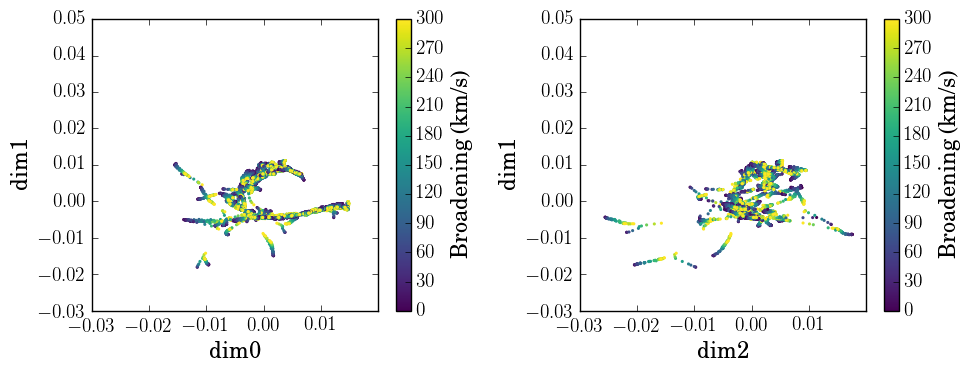

In [144]:
plot_embed(sigmas, 'Broadening (km/s)', axlim=True)

## Plots below show result for r=1.14, smallest r that gives 1 connected component

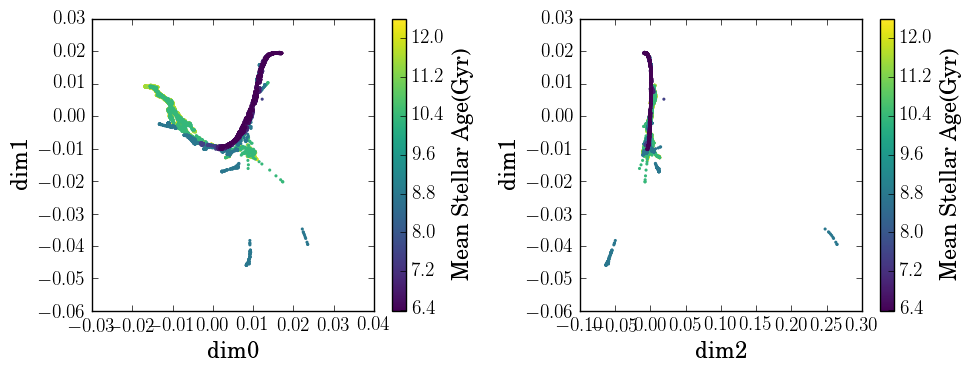

In [130]:
plot_embed(ages, 'Mean Stellar Age(Gyr)', axlim=False)

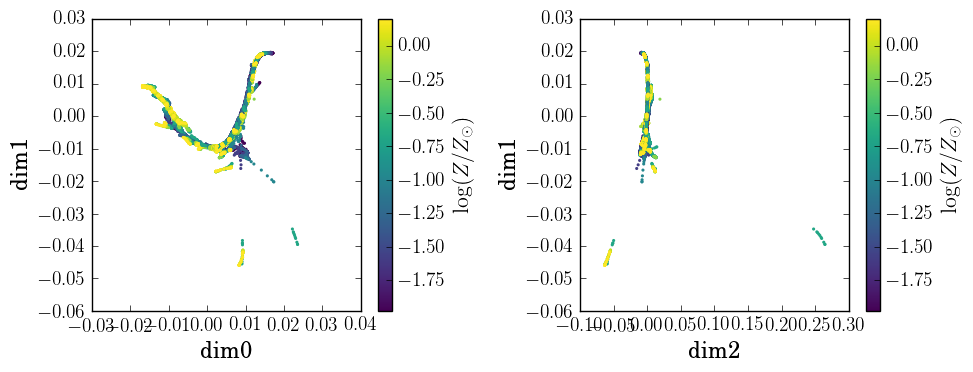

In [131]:
plot_embed(zs, r'$\log(Z/Z_\odot)$', axlim=False)

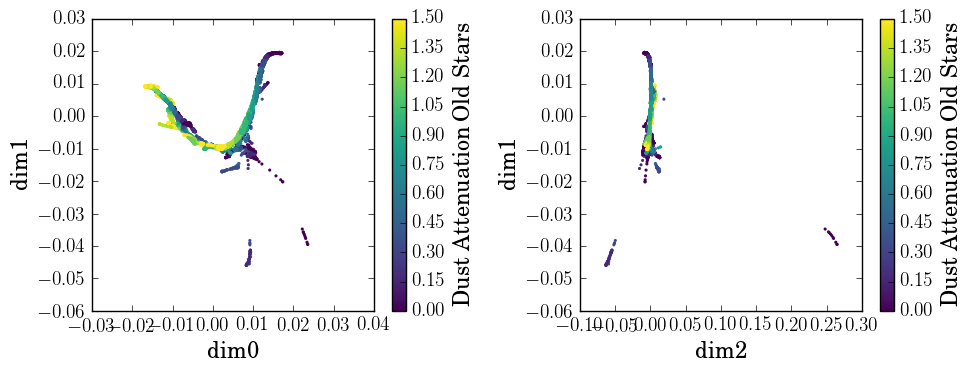

In [132]:
plot_embed(dusts, 'Dust Attenuation Old Stars', axlim=False)

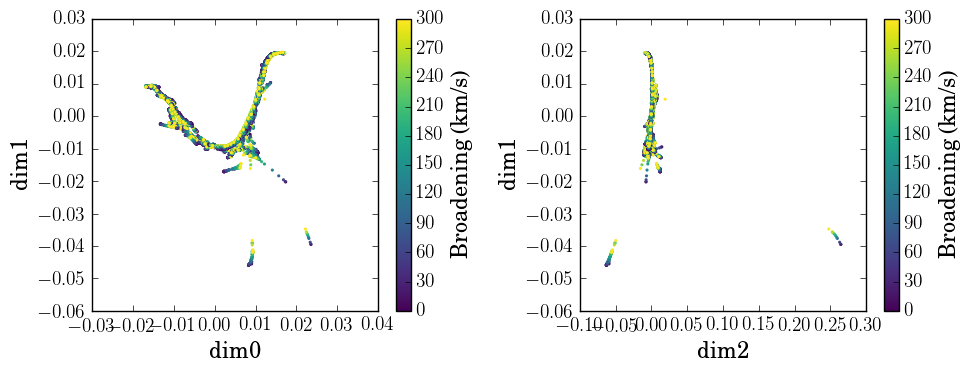

In [133]:
plot_embed(sigmas, 'Broadening (km/s)', axlim=False)

In [126]:
hmm = np.where(labels > 0)[0][:]
np.shape(hmm)

(10,)

In [127]:
for ii in hmm:
    print zip(ages, zs, dusts, sigmas)[ii]

(8.7657482395594091, -0.68999999999999995, 0.0, 0.0)
(8.7657482395594091, -0.68999999999999995, 0.0, 33.333333333333336)
(8.7657482395594091, -0.68999999999999995, 0.0, 66.666666666666671)
(8.7657482395594091, -0.68999999999999995, 0.0, 100.0)
(8.7657482395594091, -0.68999999999999995, 0.0, 133.33333333333334)
(8.7657482395594091, -0.68999999999999995, 0.0, 166.66666666666669)
(8.7657482395594091, -0.68999999999999995, 0.0, 200.0)
(8.7657482395594091, -0.68999999999999995, 0.0, 233.33333333333334)
(8.7657482395594091, -0.68999999999999995, 0.0, 266.66666666666669)
(8.7657482395594091, -0.68999999999999995, 0.0, 300.0)


In [113]:
np.unique(ages)

array([  6.38017444,   6.53018685,   6.85100965,   7.51938898,
         8.76574824,  10.38344913,  11.50004658,  12.03584112,
        12.28455653,  12.4       ])